In [1]:
import sys
import os
from torchvision import transforms

from PIL import Image
from transformers import TableTransformerForObjectDetection, AutoModelForObjectDetection


# Give priority to the modules that are inside tableTransformer 
# and handles the conflict between tableTransformer/detr/datasets and hugging face datasets' library
sys.path.insert(1, os.getcwd() + '/tableTransformer/src')
sys.path.insert(2, os.getcwd() + '/tableTransformer/detr')
# This snipet is necessary for inference to work

from tableTransformer.src.inference import TableExtractionPipeline, MaxResize, rescale_bboxes, objects_to_structures, structure_to_cells, cells_to_html, cells_to_csv, objects_to_crops # , outputs_to_objects




/home/martin/miniconda3/envs/tables-detr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def outputs_to_objects(outputs, img_size, class_idx2name):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = class_idx2name[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

class PretrainTableExtractionPipeline(TableExtractionPipeline): 
    def __init__(
        self, 
        det_device=None, str_device=None,
        det_model=None, str_model=None, 
        # det_config_path=None, str_config_path=None
    ):
        super().__init__(
            det_device=det_device, str_device=str_device,
            # det_model=det_model, str_model=str_model,

            # init from models trained with the table-transformer project
            # det_model_path=det_model_path, str_model_path=str_model_path,
            # det_config_path=det_config_path, str_config_path=str_config_path
        )
        if det_model is not None: 
            self.det_model = det_model
            self.det_model.to(det_device)
        if str_model is not None: 
            self.str_model = str_model
            self.str_model.to(str_device)

    def recognize(
        self, 
        img, tokens=[], 
        out_objects=False, 
        out_cells=False,
        out_html=False, 
        out_csv=False
    ):
        out_formats = {}
        if self.str_model is None:
            print("No structure model loaded.")
            return out_formats

        if not (out_objects or out_cells or out_html or out_csv):
            print("No output format specified")
            return out_formats

        # Transform the image how the model expects it
        img_tensor = structure_transform(img)

        # Run input image through the model
        outputs = self.str_model(img_tensor.unsqueeze(0).to(self.str_device))

        # Post-process detected objects, assign class labels
        objects = outputs_to_objects(outputs, img.size, self.str_class_idx2name)
        if out_objects:
            out_formats['objects'] = objects
        if not (out_cells or out_html or out_csv):
            return out_formats

        # Further process the detected objects so they correspond to a consistent table 
        tables_structure = objects_to_structures(objects, tokens, self.str_class_thresholds)

        # Enumerate all table cells: grid cells and spanning cells
        tables_cells = [structure_to_cells(structure, tokens)[0] for structure in tables_structure]
        if out_cells:
            out_formats['cells'] = tables_cells
        if not (out_html or out_csv):
            return out_formats

        # Convert cells to HTML
        if out_html:
            tables_htmls = [cells_to_html(cells) for cells in tables_cells]
            out_formats['html'] = tables_htmls

        # Convert cells to CSV, including flattening multi-row column headers to a single row 
        if out_csv:
            tables_csvs = [cells_to_csv(cells) for cells in tables_cells]
            out_formats['csv'] = tables_csvs

        return out_formats

    def detect(
        self, 
        img, tokens=[], 
        out_objects=True, out_crops=False, crop_padding=10
    ):
        out_formats = {}
        if self.det_model is None:
            print("No detection model loaded.")
            return out_formats

        # Transform the image how the model expects it
        img_tensor = detection_transform(img)

        # Run input image through the model
        outputs = self.det_model(img_tensor.unsqueeze(0).to(self.det_device))

        # Post-process detected objects, assign class labels
        objects = outputs_to_objects(outputs, img.size, self.det_class_idx2name)
        if out_objects:
            out_formats['objects'] = objects
        if not out_crops:
            return out_formats

        # Crop image and tokens for detected table
        if out_crops:
            tables_crops = objects_to_crops(img, tokens, objects, self.det_class_thresholds,
                                            padding=crop_padding)
            out_formats['crops'] = tables_crops

        return out_formats

In [3]:
TABLE_DETECTION_MODEL = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm") # AutoModelForObjectDetection
TABLE_STRUCTURE_MODEL = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition-v1.1-all") # -all -fin -pub

TABLE_DETECTION_DEVICE = "cpu"
TABLE_STRUCTURE_DEVICE = "cpu"

In [4]:
table_extraction_pipeline = PretrainTableExtractionPipeline(
    det_device=TABLE_DETECTION_DEVICE, 
    str_device=TABLE_STRUCTURE_DEVICE, 
    det_model=TABLE_DETECTION_MODEL,
    str_model=TABLE_STRUCTURE_MODEL
)

In [5]:
image = Image.open(f'2303.00716.PNG').convert("RGB")
width, height = image.size


# Recognize table(s) from image
extracted_tables = table_extraction_pipeline.extract(image, tokens=[], out_objects=True, out_cells=True, out_html=True, out_csv=True)

In [6]:
extracted_tables[0]['html'][0]

'<table><thead><th></th><th></th><th></th><th></th><th></th><th></th><th></th></thead><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr></table>'

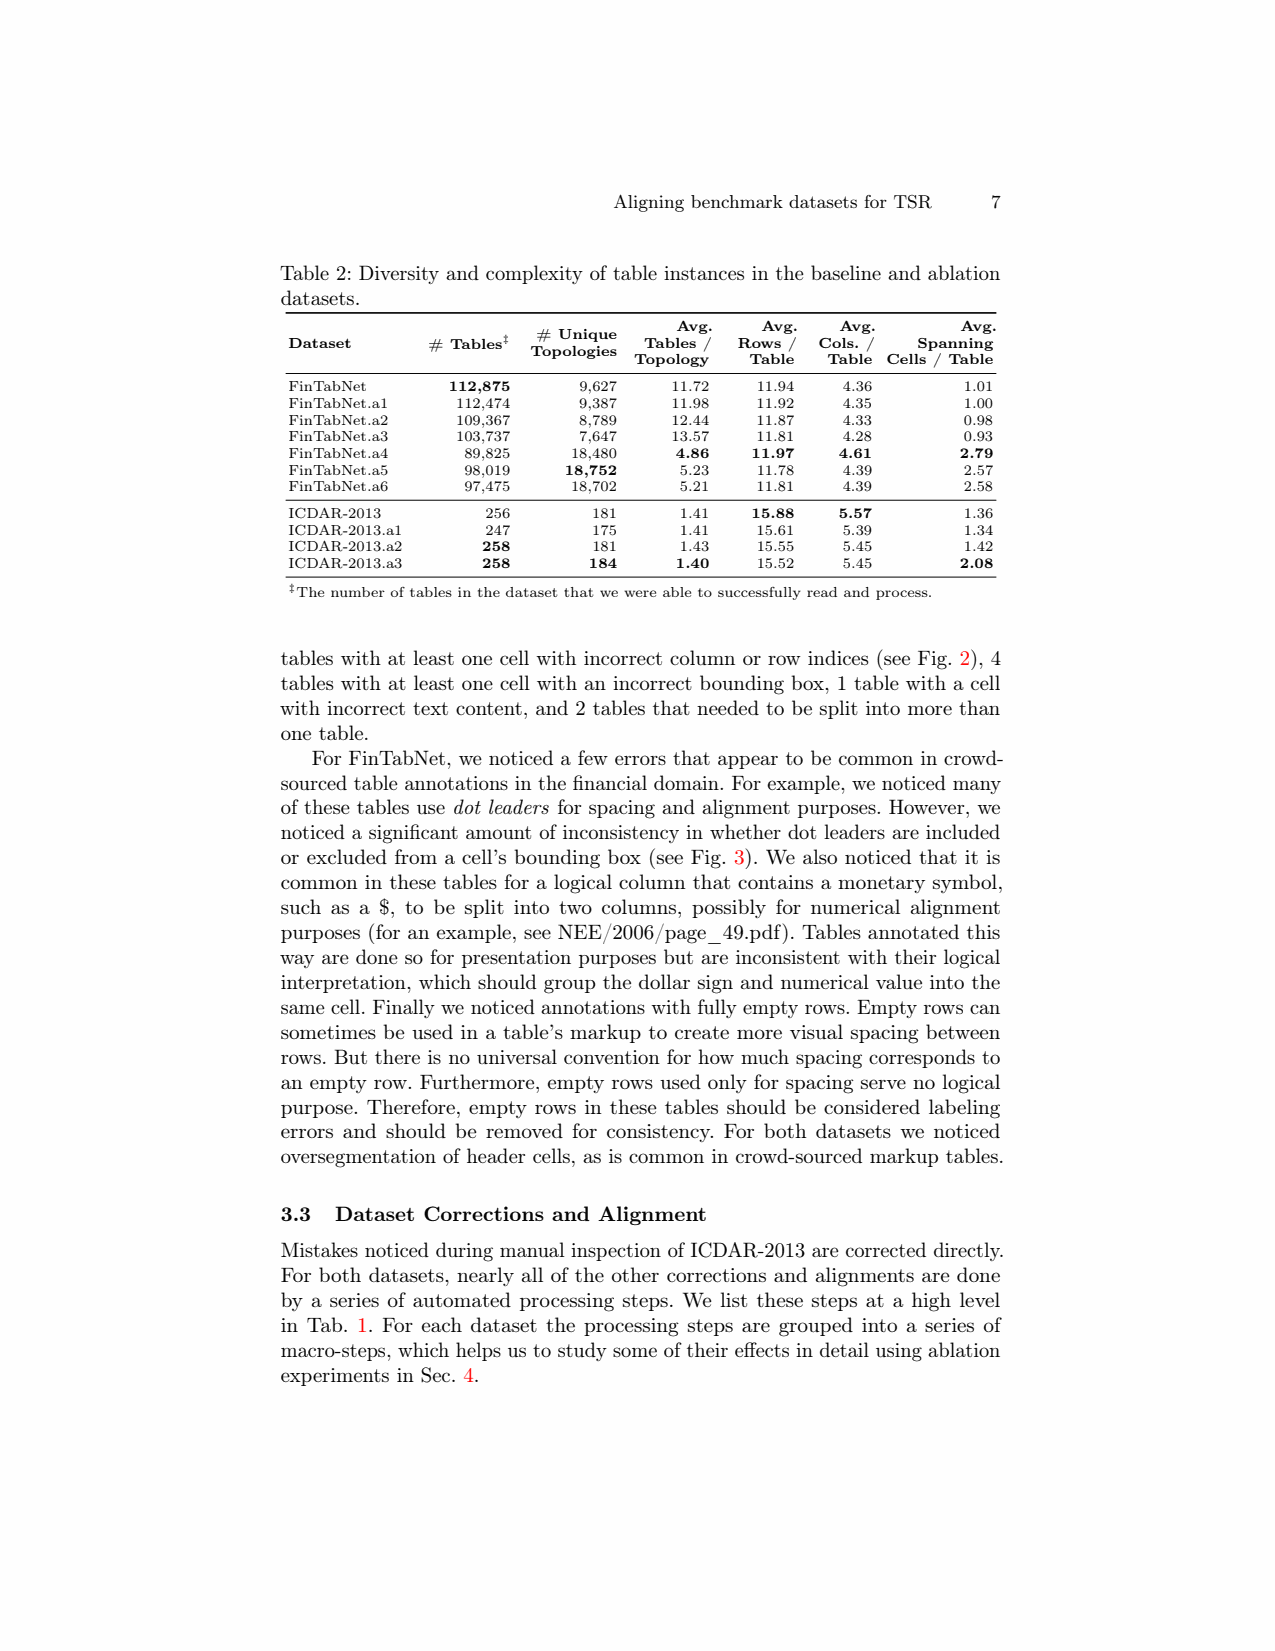

In [7]:
display(image)